In [5]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tifffile import imwrite, imread
from datagenerator_2D import data_generator


1 Physical GPUs, 1 Logical GPUs


In [61]:
GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\UNet-RCAN\Histon\results-histon\gt.tif'
lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\UNet-RCAN\Histon\results-histon\noisy.tif'
pred_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\UNet-RCAN\Histon\results-histon\pred.tif'

save_parameters_dr = r"D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\UNet-RCAN\Histon\results\histon_param.csv"

save_image_dr = r"D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\UNet-RCAN\Histon\results" 



In [77]:
patch_size =1440
n_patches = 3
n_channel =  0
add_noise =False
lp = 0.1

x_test, y_test,_,_ = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                    n_channel, threshold =0 ,ratio=1.0,lp=lp, augment=False,
                                    shuffle=False,add_noise=add_noise)

(3, 1, 2048, 2048)
27
The training set shape is: (27, 1440, 1440, 1)
The validation set shape is: (0, 1440, 1440, 1)


In [78]:
prediction1, _,_,_ = data_generator(GT_image_dr, pred_image_dr, patch_size, n_patches,
                                    n_channel, threshold =0 ,ratio=1.0,lp=lp, augment=False, 
                                    shuffle=False,add_noise=add_noise)

(3, 1, 2048, 2048)
27
The training set shape is: (27, 1440, 1440, 1)
The validation set shape is: (0, 1440, 1440, 1)


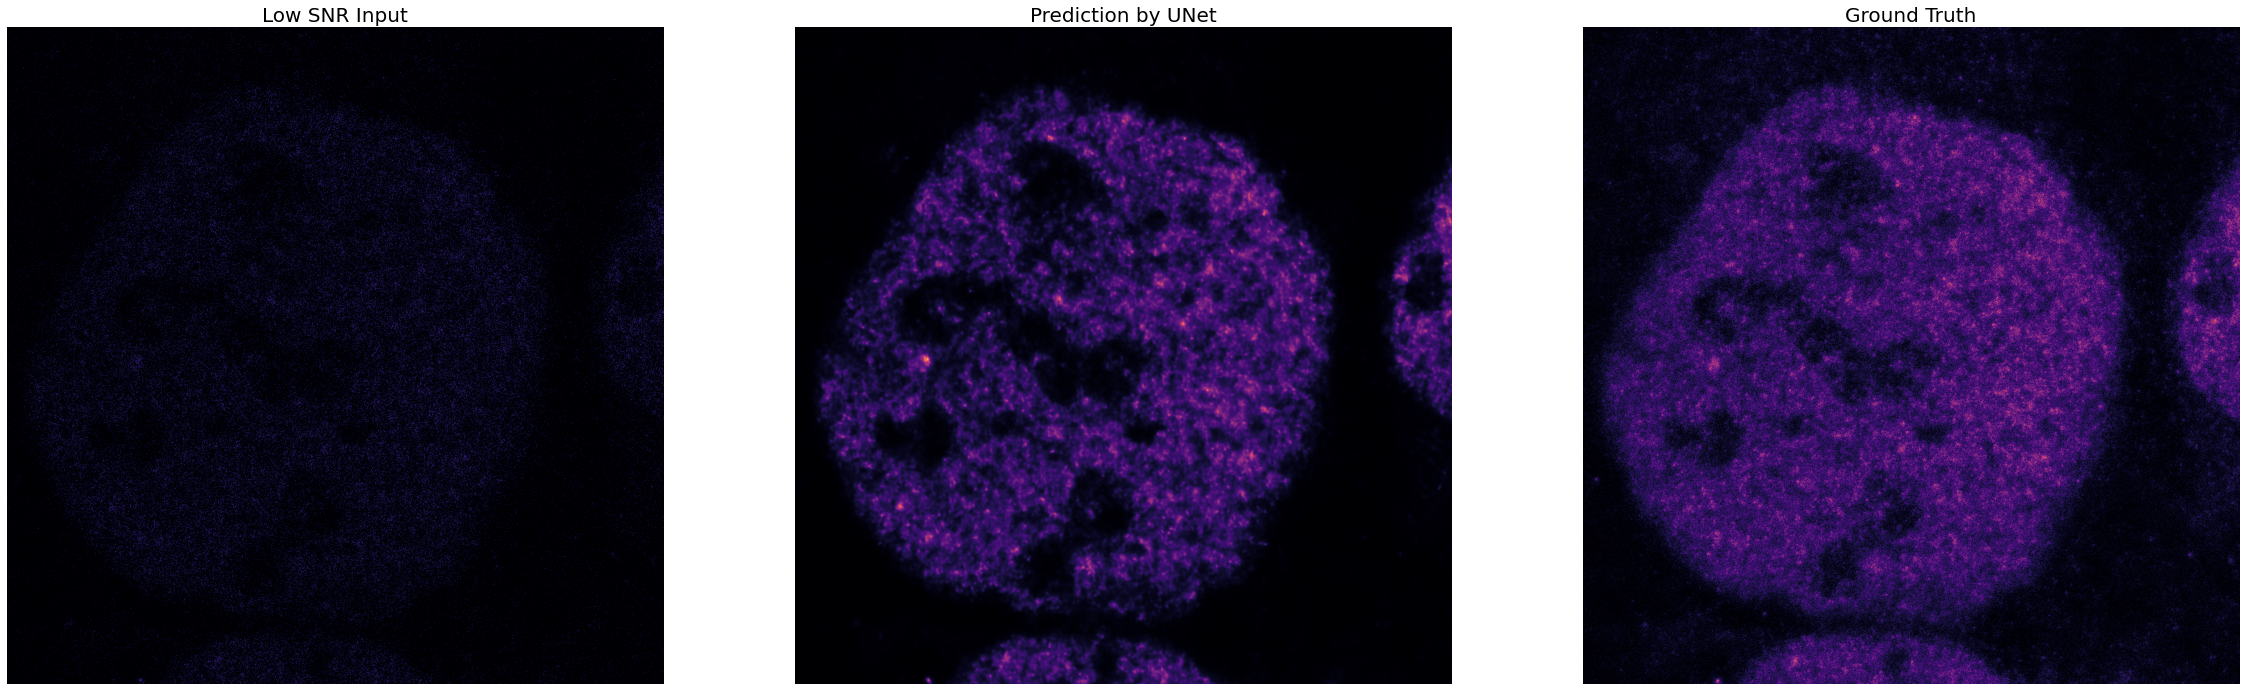

In [83]:
ix = np.random.randint(len(prediction1))
# ix = 0
fig = plt.figure(figsize=(40,40))

plt.subplot(1, 3, 1)
plt.imshow(x_test[ix, :, :, 0] , cmap='magma')
plt.title('Low SNR Input',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(prediction1[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by UNet',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_test[ix, :, :, 0] , cmap='magma')
plt.title('Ground Truth',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

In [82]:
# pred1_test = np.moveaxis(prediction1,3,1)
# pred2_test = np.moveaxis(prediction2,3,1)
# X_test = np.moveaxis(x_test,3,1)
# Y_test = np.moveaxis(y_test,3,1)


pred1_test = prediction1*(2**16-1)
X_test = x_test*(2**16-1)
Y_test = y_test*(2**16-1)

pred1_test = pred1_test.astype(np.uint16)

X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

imwrite(save_image_dr+'/pred.tif', pred1_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
imwrite(save_image_dr+'/noisy.tif', X_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
imwrite(save_image_dr+'/gt.tif', Y_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})

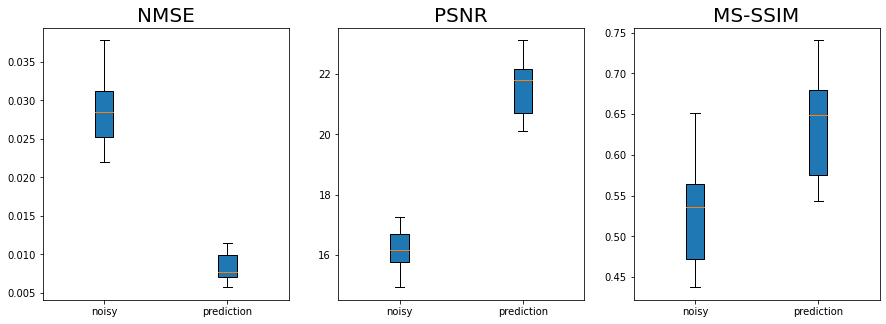

In [81]:
gam = 1.2
prediction1 = prediction1**(gam)
for i in range(len(prediction1)):
    prediction1[i] = prediction1[i]/prediction1[i].max()
    
def norm_mse(prediction, gt):
    mse = tf.keras.metrics.mean_squared_error(prediction, gt)
    mse = tf.math.reduce_sum(mse, axis=(1, 2))
    norm = tf.norm(gt, axis=(1, 2))
    norm = tf.squeeze(norm)
    norm = tf.pow(norm, 2)
    norm = tf.math.reduce_sum(norm)
    norm_mse = tf.math.divide(mse, norm)
    return norm_mse.numpy()

def nmse_psnr_ssim(prediction,gt):
    nmse = norm_mse(prediction,gt)
    psnr = tf.image.psnr(prediction, gt, max_val = 1.0).numpy()
    ssim = tf.image.ssim_multiscale(prediction, gt, max_val = 1.0, filter_size=14,
                                    filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    return nmse,psnr,ssim
    
imageq_param = np.zeros((6,len(prediction1)))

imageq_param[0::2,:] = nmse_psnr_ssim(x_test,y_test)
imageq_param[1::2,:] = nmse_psnr_ssim(prediction1,y_test)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
labels = ['noisy', 'prediction']

bplot1 = axes[0].boxplot([imageq_param[0,:],imageq_param[1,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[0].set_title('NMSE',fontsize=20)

bplot2 = axes[1].boxplot([imageq_param[2,:],imageq_param[3,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[1].set_title('PSNR',fontsize=20)

bplot3 = axes[2].boxplot([imageq_param[4,:],imageq_param[5,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
cc= axes[2].set_title('MS-SSIM',fontsize=20)


np.savetxt(save_parameters_dr, np.transpose(imageq_param), delimiter=",")